In [1]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import librosa
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Softmax, Dropout, BatchNormalization, Activation

from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

import keras

# Preprocessing

From generated chords, get the following:

- Chord name (A, B, C, D...)
- Chord type (major, minor, dimishished, diminished 7, etc.)
- instrument type

In [3]:
chord_filenames = glob("data/nsynth-train/generated_chords/*.wav")

In [4]:
len(chord_filenames)

240056

In [5]:
from collections import namedtuple
def get_chord_metadata_from_filename(filename):
    filename = filename.split("/")[-1]
    metadata_data = filename.split("_")
    meta = namedtuple("metadata", "chord_name chord_name_base chord_type instrument_family instrument_source")
    out = meta(chord_name=metadata_data[0],
               chord_name_base=''.join([i for i in metadata_data[0] if not i.isdigit()]),
               chord_type=metadata_data[1],
               instrument_family=metadata_data[2],
               instrument_source=metadata_data[3])
    
    return out

In [6]:
# Get metadata from each filename
metadata = [get_chord_metadata_from_filename(file) for file in tqdm(chord_filenames)]

In [7]:
metadata_df = pd.DataFrame.from_records(metadata)
metadata_df.columns = ["chord_name", "chord_name_base", "chord_type", "instrument_family", "instrument_source"]
metadata_df['filename'] = chord_filenames

In [8]:
metadata_df

,chord_name,chord_name_base,chord_type,instrument_family,instrument_source,filename
0,G#5,G#,min7,string,acoustic,data/nsynth-train/generated_chords/G#5_min7_st...
1,G5,G,sus2,string,acoustic,data/nsynth-train/generated_chords/G5_sus2_str...
2,G6,G,maj,string,acoustic,data/nsynth-train/generated_chords/G6_maj_stri...
3,D6,D,open5,string,acoustic,data/nsynth-train/generated_chords/D6_open5_st...
4,A6,A,min7,string,acoustic,data/nsynth-train/generated_chords/A6_min7_str...
5,A5,A,min,keyboard,acoustic,data/nsynth-train/generated_chords/A5_min_keyb...
6,F#6,F#,min,keyboard,acoustic,data/nsynth-train/generated_chords/F#6_min_key...
7,B7,B,maj,guitar,acoustic,data/nsynth-train/generated_chords/B7_maj_guit...
8,D6,D,sus4,guitar,acoustic,data/nsynth-train/generated_chords/D6_sus4_gui...
9,G2,G,aug7,keyboard,acoustic,data/nsynth-train/generated_chords/G2_aug7_key...


In [9]:
# Get counts of each of our classes
metadata_df.chord_name_base.value_counts()

D     28111
B     26900
F#    23046
A     21666
E     21129
G     20723
G#    20290
C#    19654
D#    19107
C     18126
F     13058
A#     8246
Name: chord_name_base, dtype: int64

In [10]:
metadata_df.instrument_family.value_counts()

string      112705
guitar       73553
keyboard     52688
bass          1110
Name: instrument_family, dtype: int64

# Modeling

For a first pass (faster), sample 15000 chords and see if we can get a model to learn anything

In [14]:
metadata_df_sample = metadata_df.sample(100000)
test_df_sample = metadata_df[~(metadata_df.filename.isin(metadata_df_sample.filename))].sample(10000)

In [15]:
# Import .wav files
train_x_input = [librosa.load(file, sr=16000, duration=1)[0] for file in tqdm(metadata_df_sample.filename)]

In [16]:
test_x_input = [librosa.load(file, sr=16000, duration=1)[0] for file in tqdm(test_df_sample.filename)]

In [17]:
import scipy.fftpack

In [18]:
# Convert all chords from time to frequency domain
train_x_stft = [scipy.fftpack.fft(sound)[0:8000] for sound in tqdm(train_x_input)]
train_x_stft = np.array(train_x_stft)

In [19]:
test_x_stft = [scipy.fftpack.fft(sound)[0:8000] for sound in tqdm(test_x_input)]
test_x_stft = np.array(test_x_stft)

In [33]:
# Create one hot matrix of instrument type
le_note_base = LabelEncoder()
le_note_base.fit(metadata_df_sample.chord_name_base)
train_y_note_base = to_categorical(le_note_base.transform(metadata_df_sample.chord_name_base))
test_y_note_base = to_categorical(le_note_base.transform(test_df_sample.chord_name_base))

le_instrument_family = LabelEncoder()
le_instrument_family.fit(metadata_df_sample.instrument_family)
train_y_instrument_family = to_categorical(le_instrument_family.transform(metadata_df_sample.instrument_family))
test_y_instrument_family = to_categorical(le_instrument_family.transform(test_df_sample.instrument_family))

le_chord_type = LabelEncoder()
le_chord_type.fit(metadata_df_sample.chord_type)
train_y_chord_type = to_categorical(le_chord_type.transform(metadata_df_sample.chord_type))
test_y_chord_type = to_categorical(le_chord_type.transform(test_df_sample.chord_type))

## Chord Classification

In [21]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
# lay1 = Dropout(.2)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
# lay2 = Dropout(.2)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.2)(lay3)

output = Dense(12, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                400050    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
batch_normalization_3 (Batch (None, 40)                160       
__________

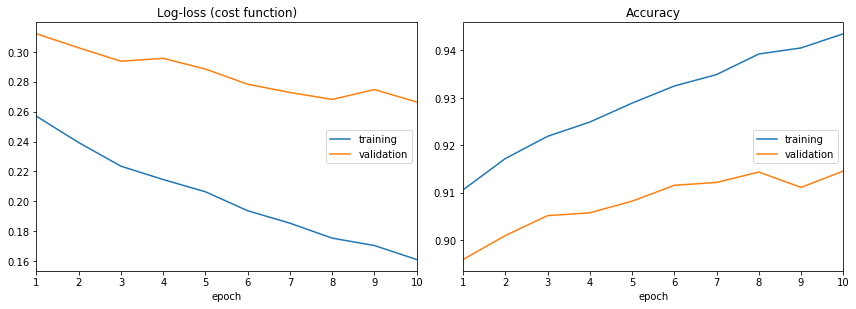

In [25]:
history = model.fit([train_x_stft],
                    train_y_note_base,
                    epochs=20,
                    batch_size=32,
                    validation_split=.20,
                    callbacks=[PlotLossesKeras()])

In [26]:
model.evaluate(test_x_stft, test_y_note_base)

 2304/10000 [=====>........................] - ETA: 0s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


10000/10000 [==============================] - 1s 59us/step


[0.2723187460184097, 0.9158]

20 epochs can predict an out of sample test set with 91 percent.

## Instrument type classification

In [38]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
# lay1 = Dropout(.2)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
# lay2 = Dropout(.2)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.2)(lay3)

output = Dense(4, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

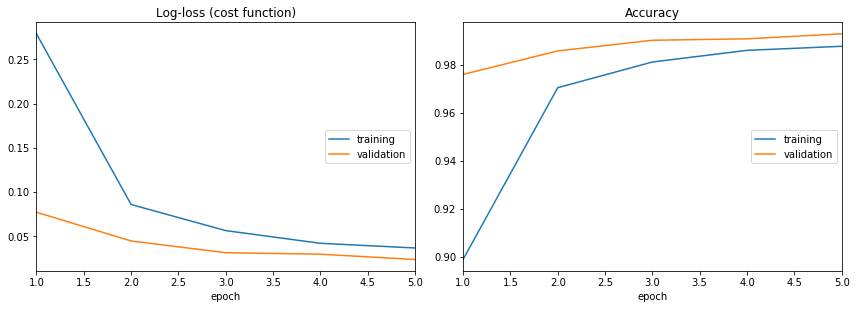

In [39]:
history = model.fit([train_x_stft],
                    train_y_instrument_family,
                    epochs=5,
                    batch_size=32,
                    validation_split=.20,
                    callbacks=[PlotLossesKeras()])

In [40]:
model.evaluate(test_x_stft, test_y_instrument_family)

 2592/10000 [======>.......................] - ETA: 0s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


10000/10000 [==============================] - 1s 60us/step


[0.017356196071207523, 0.9941]

We can predict our 4 initial instrument families (guitar, piano, strings, bass) with ~99% accuracy.  This instruments are fairly distinct from one another.  Would we expect our accuracy to decrease as we introduce more obscure instrument families into the dataset?

## Chord Type

In [44]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
# lay1 = Dropout(.2)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
# lay2 = Dropout(.2)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.2)(lay3)

output = Dense(13, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

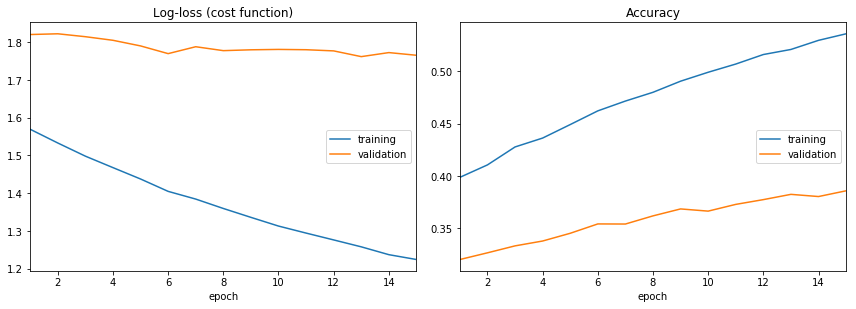

In [47]:
history = model.fit([train_x_stft],
                    train_y_chord_type,
                    epochs=20,
                    batch_size=32,
                    validation_split=.20,
                    callbacks=[PlotLossesKeras()])

In [48]:
model.evaluate(test_x_stft, test_y_chord_type)

 2496/10000 [======>.......................] - ETA: 0s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


10000/10000 [==============================] - 1s 62us/step


[1.7319471000671387, 0.3856]

Predicting the chord type (maj, min, dim, aug, etc.) appears to be a bit more difficult than the other categories. 

I wonder if this is due to more sparsity in these classes than in the others.  I suspect we may see gains here when we run with more data.

## Multi-output (predict all the predictors above in one neural net)

In [50]:
in_data = Input(shape=(8000, ))

lay1 = Dense(50, activation='relu')(in_data)
lay1 = BatchNormalization()(lay1)
# lay1 = Dropout(.2)(lay1)

lay2 = Dense(50, activation='relu')(lay1)
lay2 = BatchNormalization()(lay2)
# lay2 = Dropout(.2)(lay2)

lay3 = Dense(50, activation='relu')(lay2)
lay3 = BatchNormalization()(lay3)
# lay3 = Dropout(.2)(lay3)

output_chord_note_base = Dense(12, activation = "softmax")(lay3)
output_instrument_family = Dense(4, activation = "softmax")(lay3)
output_chord_type = Dense(13, activation = "softmax")(lay3)

model = Model(inputs=[in_data],
              outputs=[output_chord_note_base, output_instrument_family, output_chord_type])

model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['acc'])

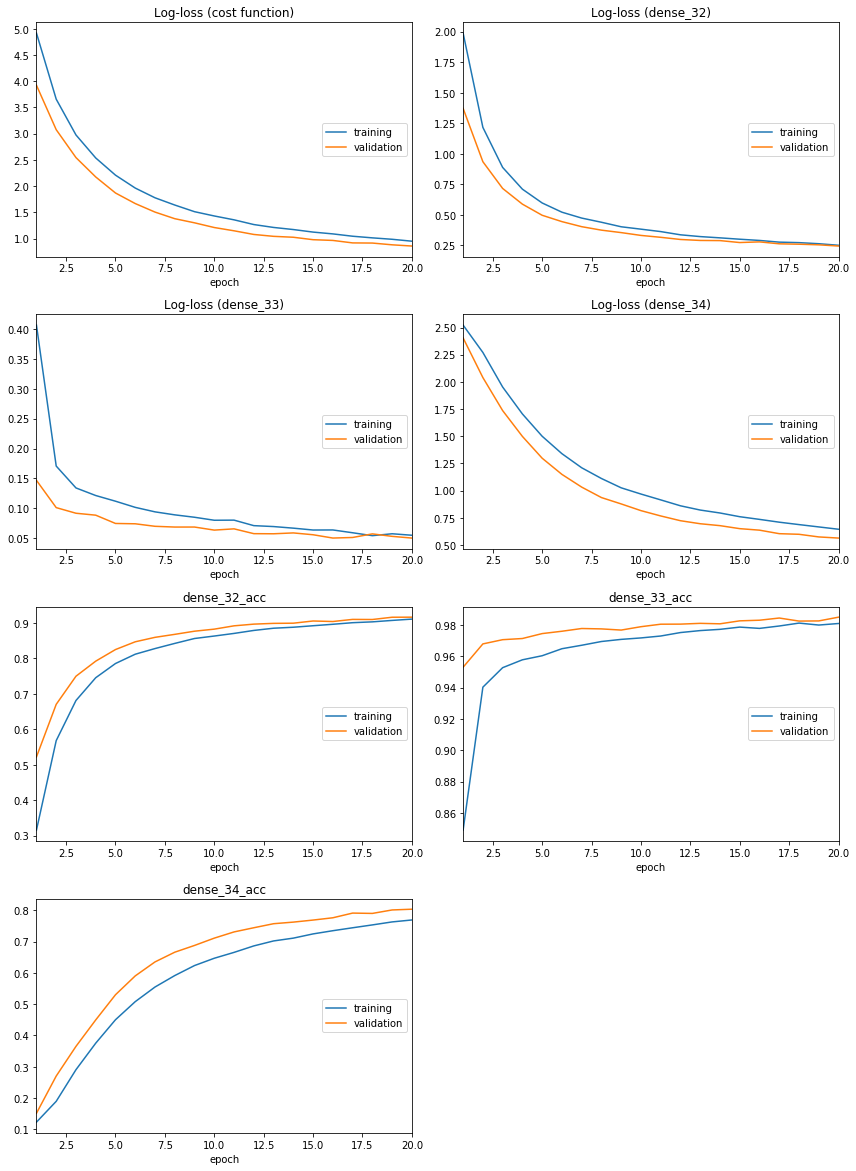

In [51]:
history = model.fit([train_x_stft],
                    [train_y_note_base, train_y_instrument_family, train_y_chord_type],
                    epochs=20,
                    batch_size=32,
                    validation_split=.20,
                    callbacks=[PlotLossesKeras()])

In [52]:
model.evaluate(test_x_stft, [test_y_note_base, test_y_instrument_family, test_y_chord_type])

  608/10000 [>.............................] - ETA: 2s

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


10000/10000 [==============================] - 3s 263us/step


[0.8738431469917297,
 0.24573602641820907,
 0.062028516425937416,
 0.5660786041736603,
 0.9152,
 0.9822,
 0.803]

A very interesting observation is that the classification accuracy for chord type is significantly higher than when it was trained alone.  This could potentially be due to a "lucky" random initialization of parameters.

It is possible, though, that information from the other classes backpropagation adjusted the weights in such a way that helped the classification?

# TO DOs:

- Generate chords for more instruments and see if we can still get high accuracy when we increase that
- Potentially play with more instrument sources.  All these chords are from acoustic instrumentation, but we can generate data from "synthetic" as well as "electronic" instrumentation as well
- Run model with all data and see if we can push accuracy further
- Play around more with model architecture and see if that does anything.  I completely 100% arbitrarily selected the one I used. 